## STAR-RIS Aided Multi-Cell NOMA

### Necessary Imports

In [1]:
import os
import sys

sys.path.append(os.path.abspath("/home/zonularity/comm-fyp/"))

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy.stats import rayleigh, rice
import simcomm
from simcomm.fading import generate_channel

plt.style.use("default")
plt.rcParams["figure.figsize"] = (6, 4)

### System Model

Parameters

In [ ]:
# Multi-cell NOMA
N = 3  # Number of users
N_index = np.arange(N)  # Index of users
M = 2  # Number of BSs and RISs
M_index = np.arange(M)  # Index of BSs
AREA = 500  # Area of the simulation m^2
ETA = 4  # path loss exponent
BANDWIDTH = 1e6  # bandwidth in Hz
NOISE = -144 + 10 * np.log10(BANDWIDTH)  # noise power in dBm
NOISE_LIN = 10 ** (NOISE / 10) / 1000  # noise power in linear scale
K = 5   # number of bits to be transmitted
L = 10  # number of RIS elements
K_rice = 3  # Rician factor in dB

# Power parameters
Pt = np.linspace(-30, 30, 60)  # transmit power in dBm
Pt_lin = 10 ** (Pt / 10) / 1000  # transmit power in linear scale
P_circuit = 1e-2  # circuit power in Watts

Creating Layout

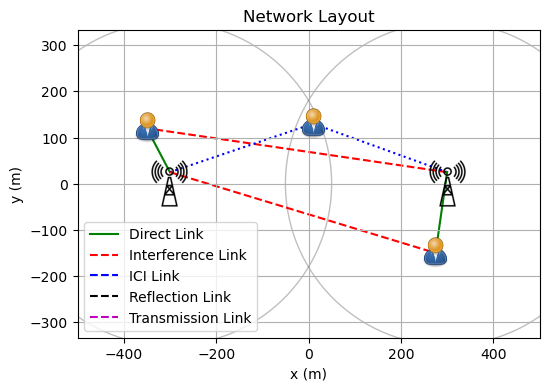

In [35]:
bs_pos = np.array([[-300, 0], [300, 0]])
user_pos = np.array([[-350, 120], [10, 130], [275, -150]])
ris_pos = np.array([[-100, 5], [100, -5]])

plot_network(500, bs_pos, user_pos, None)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.image import imread

# Placing the base stations
bs_pos = np.array([[-300, 0], [300, 0]])
user_pos = np.array([[-350, 120], [10, 130], [275, -150]])
ris_pos = np.array([[-100, 5], [100, -5]])

# Plotting the layout
fig, ax = plt.subplots(figsize=(6, 4))
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.xlim([-AREA, AREA])
plt.ylim([-AREA / 1.5, AREA / 1.5])
plt.grid()

for bs in bs_pos:
    circle = Circle(bs, radius=350, fill=False, alpha=0.25)
    ax.add_patch(circle)
    bs_img = imread("../resources/bs.png")
    plt.imshow(
        bs_img, extent=[bs[0] - 40, bs[0] + 40, bs[1] - 50, bs[1] + 50], zorder=2
    )

for i, bs in enumerate(bs_pos):
    for j, ris in enumerate(ris_pos):
        if i == j:
            plt.plot([bs[0], ris[0]], [bs[1], ris[1]], "k-", zorder=1)

for user in user_pos:
    for bs in bs_pos:
        if np.linalg.norm(user - bs) == np.min(np.linalg.norm(user_pos - bs, axis=1)):
            plt.plot([bs[0], user[0]], [bs[1] + 25, user[1]], "g-", zorder=1)
        else:
            if (user == user_pos[1]).all():
                plt.plot([bs[0], user[0]], [
                         bs[1] + 25, user[1]], "b:", zorder=1)
            else:
                plt.plot([bs[0], user[0]], [
                         bs[1] + 25, user[1]], "r--", zorder=1)
    user_img = imread("../resources/user.png")
    plt.imshow(
        user_img,
        extent=[user[0] - 35, user[0] + 35, user[1] - 35, user[1] + 35],
        zorder=2,
    )

for ris in ris_pos:
    ris_img = imread("../resources/starris.png")
    plt.imshow(
        ris_img, extent=[ris[0] - 60, ris[0] + 60, ris[1] - 80, ris[1] + 80], zorder=0
    )

for i, ris in enumerate(ris_pos):
    for j, user in enumerate(user_pos):
        if j == 0 and i == 0:
            plt.plot([ris[0], user[0]], [ris[1], user[1]], "k--", zorder=1)
        elif j == 1 and (i == 0 or i == 1):
            plt.plot([ris[0], user[0]], [ris[1], user[1]], "m--", zorder=1)
        elif j == 2 and i == 1:
            plt.plot([ris[0], user[0]], [ris[1], user[1]], "k--", zorder=1)

plt.plot([], [], "g-", label="Direct Link", zorder=1)
plt.plot([], [], "r--", label="Interference Link", zorder=1)
plt.plot([], [], "b--", label="ICI Link", zorder=1)
plt.plot([], [], "k--", label="Reflection Link", zorder=1)
plt.plot([], [], "m--", label="Transmission Link", zorder=1)

plt.title("Network Layout")
plt.legend()
plt.show()

### System Matrices

In [ ]:
# Find distances between network elements
distance_mn = np.sqrt(np.sum((user_pos[:, np.newaxis, :] - bs_pos) ** 2, axis=-1))
distance_mr = np.sqrt(np.sum((ris_pos - bs_pos) ** 2, axis=-1))
distance_rn = np.sqrt(np.sum((user_pos[:, np.newaxis, :] - ris_pos) ** 2, axis=-1))

# Generate rayleigh channel coefficients
h_mn = np.zeros((N, M, K // 2), dtype=np.complex128)

for i in range(M):
    for j in range(N):
        h_mn[j, i, :] = (
            np.sqrt(distance_mn[j, i] ** (-ETA))
            * (rayleigh.rvs(size=K // 2) + 1j * rayleigh.rvs(size=K // 2))
            / np.sqrt(2)
        )

h_mr = np.zeros((L, M, K // 2), dtype=np.complex128)
h_rn = np.zeros((L, N - 1, M, K // 2), dtype=np.complex128)

# fmt: off
# Generate rice channel coefficients from base station to RISs
# Channel between BS 1 >> RIS 1
# Channel between BS 2 >> RIS 2
for i in range(M):
    for j in range(L):
        h_mr[j, i, :] = (
            np.sqrt(distance_mr[i] ** (-ETA))
                * ((np.sqrt(1 / (1 + K_rice)) * (rayleigh.rvs(size=K // 2) + 1j * rayleigh.rvs(size=K // 2)))
                    + (np.sqrt(K_rice / (1 + K_rice)) * (rice.rvs(b=K_rice, size=K // 2)
                            + 1j * rice.rvs(b=K_rice, size=K // 2)))) / np.sqrt(2)
            )
        
user_group = np.array([[0, 1], [1, 2]])

# Generate rice channel coefficients from RISs to users
# Channel between RIS 1 >> user [0, 1]
# Channel between RIS 2 >> user [1, 2]
for i in range(M):
    group = user_group[i]
    for j in range(L):
        for k in [0, 1]:
            h_rn[j, k, i, :] = (
                np.sqrt(distance_rn[k, i] ** (-ETA))
                * ((np.sqrt(1 / (1 + K_rice)) * (rayleigh.rvs(size=K // 2) + 1j * rayleigh.rvs(size=K // 2)))
                    + (np.sqrt(K_rice / (1 + K_rice)) * (rice.rvs(b=K_rice, size=K // 2)
                            + 1j * rice.rvs(b=K_rice, size=K // 2)))) / np.sqrt(2)
            )
# fmt: on

In [ ]:
# Reflection and Transmission coefficient matrices
theta_r = np.zeros((L, L, K // 2), dtype=np.complex128)
beta_r = np.zeros((L, K // 2), dtype=np.float64)

theta_t = np.zeros((L, L, K // 2), dtype=np.complex128)
beta_t = np.zeros((L, K // 2), dtype=np.float64)

epsilon = 1e-5

for i in range(L):
    beta_r[i, :] = np.random.rand(K // 2) + epsilon
    beta_t[i, :] = 1 - beta_r[i, :]
    theta_r[i, i, :] = beta_r[i, :] * np.exp(
        1j * np.random.uniform(0, 2 * np.pi, K // 2)
    )
    theta_t[i, i, :] = beta_t[i, :] * np.exp(
        1j * np.random.uniform(0, 2 * np.pi, K // 2)
    )

In [ ]:
# Combined channel from BS >> RIS >> user
H_mn = np.zeros((N - 1, M, L, L, K // 2), dtype=np.complex128)

for i in range(M):
    group = user_group[i]
    for k in [0, 1]:
        H_mn[int(np.ceil(k / 2)), i] = (
            h_mn[int(np.ceil(k / 2)), i, np.newaxis]
            + np.swapaxes(np.conj(h_rn[:, int(np.ceil(k / 2)), i, np.newaxis]), 0, 1)
            * theta_r
            * h_mr[:, i, np.newaxis]
        )

In [ ]:
# Finding channel gains
g_mn = np.abs(h_mn) ** 2  # direct channel gain
G_mn = np.abs(H_mn) ** 2  # combined channel gain

print("Direct Channel Gain:")
print(g_mn.mean(axis=-1))

print("\nCombined Channel Gain:")
print(G_mn[:, :, 3, 3].mean(axis=-1))

In [ ]:
G_mn[1, 0]

In [ ]:
# Generating noise
noise_mat = np.sqrt(NOISE_LIN / 2) * (
    np.random.randn(N, M, K // 2) + 1j * np.random.randn(N, M, K // 2)
)

print("Noise:")
print(noise_mat)

### Power Allocation Factor

In [ ]:
# Assigning alpha factors for fixed allocation
alpha = np.zeros((N - 1, M))
alpha[:, 0] = (0.25, 0.75)
alpha[:, 1] = (0.25, 0.75)

print("Fixed Allocation Alpha:")
print(alpha)

### Analysis

In [ ]:
rate = np.zeros((N, K // 2))
user_rate = np.zeros((N, len(Pt_lin)))
sum_rate = np.zeros(len(Pt_lin))
outage = np.zeros((N, len(Pt_lin)))
r_min = 1
energy_eff = np.zeros(len(Pt_lin))
spectral_eff = np.zeros(len(Pt_lin))

for i in range(len(Pt_lin)):
    # rate for user 1
    rate[0, :] = np.log2(
        1
        + Pt_lin[i]
        * alpha[0, 0]
        * g[0, 0, :]
        / (NOISE_LIN + Pt_lin[i] * alpha[0, 0] * g[0, 1, :])
    )

    # rate for user 2
    rate[1, :] = np.log2(
        1
        + Pt_lin[i]
        * (alpha[0, 1] * g[1, 0, :] + alpha[1, 0] * g[1, 1, :])
        / (
            Pt_lin[i] * alpha[0, 0] * g[1, 0, :]
            + Pt_lin[i] * alpha[1, 1] * g[1, 1, :]
            + NOISE_LIN
        )
    )

    # rate for user 3
    rate[2, :] = np.log2(
        1
        + Pt_lin[i]
        * alpha[1, 1]
        * g[2, 1, :]
        / (NOISE_LIN + Pt_lin[i] * alpha[1, 1] * g[2, 0, :])
    )

    # sum rate
    user_rate[0, i] = np.mean(rate[0, :])
    user_rate[1, i] = np.mean(rate[1, :])
    user_rate[2, i] = np.mean(rate[2, :])
    sum_rate[i] = np.sum(np.mean(rate, axis=1))

    # outage probability
    for k in range(K // 2):
        if rate[0, k] < r_min:
            outage[0, i] += 1
        if rate[1, k] < r_min:
            outage[1, i] += 1
        if rate[2, k] < r_min:
            outage[2, i] += 1

    # SE-EE tradeoff
    spectral_eff[i] = sum_rate[i]  # already normalized by bandwidth
    energy_eff[i] = sum_rate[i] / (Pt_lin[i] + P_circuit)

outage /= K // 2

### Plots

In [ ]:
# user rates vs transmit power
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(Pt, user_rate[0, :], "g-", label="User 1")
plt.plot(Pt, user_rate[1, :], "r-", label="User 2 (ICI)")
plt.plot(Pt, user_rate[2, :], "m-", label="User 3")
plt.xlabel("Transmit Power (dBm)")
plt.ylabel("Rate (bps/Hz)")
plt.title("User Rates vs Transmit Power")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# sum rate vs transmit power
fig = plt.figure(figsize=(6, 4))
plt.plot(Pt, sum_rate, "b-", label="Sum Rate",
         linewidth=1, marker="o", markevery=5)
plt.xlabel("Transmit Power (dBm)")
plt.ylabel("Rate (bps/Hz)")
plt.title("Sum Rate vs Transmit Power")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# outage probability vs transmit power
fig, ax = plt.subplots(figsize=(6, 4))
plt.semilogy(Pt, outage[0, :], label="User 1",
             marker="o", linewidth=2, markevery=5)
plt.semilogy(
    Pt, outage[1, :], label="User 2 (ICI)", marker="o", linewidth=2, markevery=5
)
plt.semilogy(Pt, outage[2, :], label="User 3",
             marker="o", linewidth=2, markevery=5)
plt.xlabel("Transmit Power (dBm)")
plt.ylabel("Outage Probability")
plt.title("Outage Probability vs Transmit Power")
plt.xlim([-10, 20])
plt.ylim([1e-3, 1])
plt.legend()
plt.grid(which="both")
plt.show()

In [ ]:
# SE-EE tradeoff
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(spectral_eff, energy_eff, "b-", linewidth=1)
plt.xlabel("Spectral Efficiency (bps/Hz)")
plt.ylabel("Energy Efficiency (bps/Joule)")
plt.title("SE-EE Tradeoff")
plt.grid()

# Find the peak point
peak_idx = np.argmax(energy_eff)
peak_x = spectral_eff[peak_idx]
peak_y = energy_eff[peak_idx]

# Add a marker at the peak point
plt.plot(peak_x, peak_y, marker="d", markersize=8, color="black")
plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
plt.show()